# Tutorial: Using NiftyNet to Train U-Net for Cell Segmentation 

## The problem: 

U-Net [1] is one of the (if not **_the_**) most popular neural net architecture in medical image computing. Its 2015 publication demonstrated a range of world-leading results on a variety of datasets. In this demonstration, we will show you how to use NiftyNet, an open-source platform for deep learning in medical image computing and computer assisted intervention, to train a U-Net and match these results. We also demonstrate how to test various configurations to compare different approaches (for example, which augmentation steps to use). 

## What's here: 

1. [Setup](#setup)
2. [The data](#data)
3. [The architecture](#arch)
4. [The loss function](#loss)
5. [Visualising the Data](#vis)
6. [Data Augmentation](#aug)
7. [Configuration Files](#conf)
8. [The Experiments](#exp)
9. [Monitoring Training Progress](#tb)


<a id="setup"></a>
## The setup:
To replicate the paper's results, we have to look at: 

<a id="data"></a>

## The data: 
The U-Net paper operated on several different datasets from the "ISBI Cell Tracking Challenge 2015". To get access to these datasets, you can sign up [here](http://www.celltrackingchallenge.net/datasets.html). 

This paper shows results on the "PhC-U373" dataset, and the "DIC-HeLa" dataset. 

To run this demonstration as-is, download these datasets and unzip to `./data/u-net`. You should see the following folders at this location now: 

```
DIC-C2DH-HeLa  
PhC-C2DH-U373
```

Then run the following command: 

```python -m demos.unet.file_sorter```

to arrange the files in a more convenient way for us. 


<a id="arch"></a>
## The architecture: 

In terms of implementing the specific u-net architecture, we're in luck! NiftyNet has the 2-d unet implemented already. It's located at `niftynet.networks.unet_2d`, which you can find by searching the term `"unet"` at the [documentation page](http://niftynet.readthedocs.io/en/dev/) of NiftyNet.

<a id="loss"></a>
## The loss function: 

U-Net uses a weighted cross-entropy as its loss function. The per-pixel weights are given by a formula which: 

1. balances the weights between classes and 
2. has an extra term to penalise joining two bits of the segmentation. 


$$w(x) = w_c(x) + w_0 . exp \left( -\frac{(d_1(x) + d_2(x))^2}{2\sigma^2} \right)$$

which is equation 2 in the original paper. NiftyNet supports weighted loss functions, but we are going to have to create the weights ourselves. To do that, we can write a python script to generate these weights: 

The file I used to make these weights is in `demos/unet/make_cell_weights.py`

We'll have a look at some of the data here: 


In [159]:
import os 
import nibabel as nib 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.io import imread
import re

%matplotlib inline
def plot_slides(images, figsize=(10,5)):
    f, axes = plt.subplots(2,3, figsize=figsize)
    for i, slice_id in enumerate(images):
        axes[i][0].imshow(images[slice_id]['img'], cmap='gray')
        axes[i][0].set_title('Image %s' % slice_id)
        axes[i][1].imshow(images[slice_id]['seg'], cmap='gray')
        axes[i][1].set_title('Segmentation %s' % slice_id)
        axes[i][2].imshow(images[slice_id]['weight'], cmap='jet', vmin=0, vmax=10)
        axes[i][2].set_title('Weight Map %s' % slice_id)

        for ax in axes[i]:
            ax.set_axis_off()
    f.tight_layout()

    
def grab_demo_images(image_dir, slice_ids, image_prefix_dict):
    images = {slice_id: {
            key: imread(os.path.join(image_dir, image_prefix_dict[key] + '%s.tif' % slice_id))
            for key in image_prefix_dict} 
        for slice_id in slice_ids}
    return images
    

<a id="vis"></a>

## Visualising the data

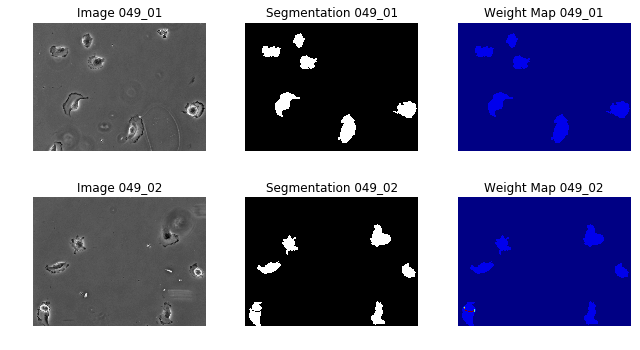

In [165]:
U373_dir = "/home/zeatonro/Projects/unet-demo/data/u-net/PhC-C2DH-U373/niftynet_data"
U373_imgs = grab_demo_images(U373_dir, ['049_01', '049_02'], {'img': 'img_', 'seg': 'bin_seg_', 'weight': 'weight_'})

plot_slides(U373_imgs, figsize=(9,5))

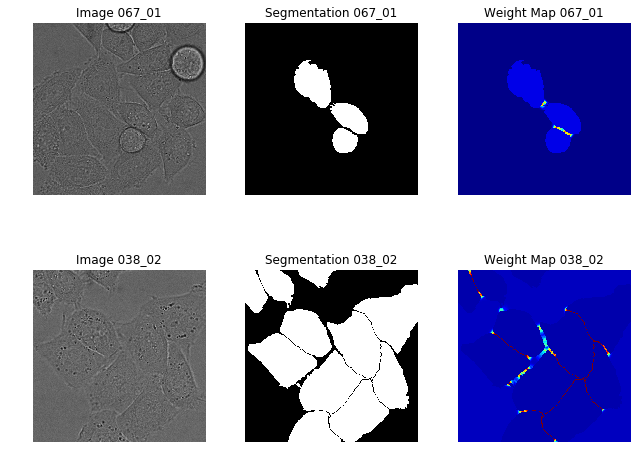

In [164]:
HeLa_dir = "/home/zeatonro/Projects/unet-demo/data/u-net/DIC-C2DH-HeLa/niftynet_data/"
HeLa_images = grab_demo_images(HeLa_dir, ['067_01', '038_02'], {'img': 'img_', 'seg': 'bin_seg_', 'weight':'weight_'})

plot_slides(HeLa_images, figsize=(9, 7))

These results look very similar to those in Figure 3 of the original paper, so we seem to be on the right track. To do this, I eroded some of the segmentation boundaries to ensure the model learns to predict the gaps between cells, as noted in the U-Net paper. 

<a id="aug"></a>

## Data augmentation: 

In U-Net, the authors use augmentation via non-linear deformation. Searching the [documentation page](http://niftynet.readthedocs.io/en/dev/)  for deformation, I can see that there is an implementation of elastic deformation in `niftynet.layer.rand_elastic_deform module`. We will use this augmentation to create variety in our training set, which should improve generalisation to unseen data. 

**Other things:** It can be useful to track the performance on a validation set during training. To do this, NiftyNet uses a `dataset_split` csv file which allows the data to be labelled as training, validation or evaluation. Because the data for these challenges is quite small, we will use only a few images for validation monitoring.

<a id="conf"></a>
## The config file: 

To set all the options, we will use a configuration file. This will include file paths, which network to use, and other options. 

There is guidance on config files available [here](https://github.com/NifTK/NiftyNet/tree/dev/config). 

We will base our configuration files on the `config/default_segmentation.ini` file in the repository. 

Here, we go through it step-by-step: 

## Data: 

Here, I show what I've changed from the default example. 

```diff
############################ input configuration sections
-[modality1]
+[cells]   # you can name this whatever you want
-csv_file=  # we will find the images by searching
-path_to_search = ./example_volumes/monomodal_parcellation
+path_to_search = ./data/u-net/PhC-C2DH-U373/niftynet_data
-filename_contains = T1
+filename_contains = t
-filename_not_contains =
-spatial_window_size = (20, 42, 42)
+spatial_window_size = (572, 572, 1)  
interp_order = 3
-pixdim=(1.0, 1.0, 1.0)
-axcodes=(A, R, S)
+loader = skimage

[label]
-path_to_search = ./example_volumes/monomodal_parcellation
+./data/u-net/PhC-C2DH-U373/niftynet_data
-filename_contains = Label
+filename_contains = bin_seg_
filename_not_contains =
-spatial_window_size = (20, 42, 42)
+spatial_window_size = (388, 388, 1)
interp_order = 0
-pixdim=(1.0, 1.0, 1.0)
-axcodes=(A, R, S)
+loader = skimage

+[xent_weights]  # pre-computed cross-entropy weights 
+path_to_search = ./data/u-net/PhC-C2DH-U373/niftynet_data
+filename_contains = weight_
+filename_not_contains =
+spatial_window_size = (388, 388, 1)
+interp_order = 3
+loader = skimage

```

I've taken out the bits that look relevant, and also added something to load in the weights for the loss function. 

The differences: we need to use a loader other than nibabel (I chose skimage, although there are other options). This is to avoid converting the images to nifti before training. We load in binary segmentations for training, although you could also explicitly tell NiftyNet to match all non-zero labels to 1. This way is slightly easier for us to visualise as users, and do appropriate checks.  



## System Parameters 
```diff
[SYSTEM]
cuda_devices = ""
-num_threads = 2
+num_threads = 10
num_gpus = 1
-model_dir = ./models/model_monomodal_toy
```
For the `SYSTEM` parameters, I increased the number of threads (my machine is pretty hefty) and deleted the model directory (we will set this later). 


## Network 

```diff
[NETWORK]
-name = toynet
+name = unet_2d 
-activation_function = prelu
+activation_function = relu 
- batch_size = 1
+ batch_size = 4 
- decay = 0.1
- reg_type = L2

# volume level preprocessing
-volume_padding_size = 21
+volume_padding_size = (92, 92, 0)

-# histogram normalisation
-histogram_ref_file = ./example_volumes/monomodal_parcellation/standardisation_models.txt
-norm_type = percentile
-cutoff = (0.01, 0.99)
normalisation = False
-whitening = False
+whitening = True
-normalise_foreground_only=True
+normalise_foreground_only=False
-foreground_type = otsu_plus
-multimod_foreground_type = and

queue_length = 20
```

I have told the network to use U-Net, and also changed the default normalisation options. I do not want 'foreground' normalisation, as our images take up the whole field of view of the image file. I need the volume padding, because U-Net wouldn't produce segmentation results for voxels near the border otherwise. 


## Training

```diff
[TRAINING]
-sample_per_volume = 32
+sample_per_volume = 2
-rotation_angle = (-10.0, 10.0)
-scaling_percentage = (-10.0, 10.0)
-random_flipping_axes= 1
+random_flipping_axes= 0, 1
-lr = 0.01
+lr = 0.0003
-loss_type = Dice
+loss_type = CrossEntropy
starting_iter = 0
-save_every_n = 100
+save_every_n = 500
-max_iter = 10
+max_iter = 10000
max_checkpoints = 20

+do_elastic_deformation = True
+deformation_sigma = 50
+num_ctrl_points = 6
+proportion_to_deform=0.9

+validation_every_n = 10
+validation_max_iter = 1

```

The major things I have changed here relate are the loss function and the augmentation. I use the (weighted) cross-entropy, as per the original paper. I also add some instructions for the elastic deformation. Finally, I add an instruction for validation to occur every ten iterations. For the specific deformation parameters, I have determined these by independent experimentation (not shown here). 

## Inference

```diff
[INFERENCE]
-border = (0, 0, 1)
+border = (92, 92, 0)  # please note the zero-entry in the last dimension. 
-#inference_iter = 10
+inference_iter = -1 # use last available checkpoint for inference
-save_seg_dir = ./output/toy
+save_seg_dir = ./output
output_interp_order = 0
-spatial_window_size = (0, 0, 3)
+spatial_window_size = (572, 572, 1)
```

These changes all relate to the specific requirements of 2-d U-Net.


## Wrapping up: 

We just have to tell the network the final details. 

```diff
[SEGMENTATION]
-image = modality1
+image = cells
label = label
+weight = xent_weights
output_prob = False
-num_classes = 160
+num_classes = 2
-label_normalisation = True
+label_normalisation = False

```

`label normalisation` is unnecessary, as we already binarised the segmentations ourselves. Otherwise, this is a case of telling the `segmentation` application how to use the data we've specified. 

<a id="exp"></a>

# The Experiments: 


Although there are many experiments you could do, I will do a simple one: 

Which augmentation methods lead to the best performance of the segmentation tool? 

To do this, I will vary the augmentation: I will either do: 

1. no augmentation (baseline) 
2. random flips 
3. elastic deformation 
4. flips + deformation 

To do this, I will create similar `.ini` files, with difference augmentation options and `model_dir` parameter. 

You can see the approach I took to do this in the file `/demos/unet/generate_run_commands.py`. Here, I programmatically generate different test conditions. I do this by using the fact that command line options override any options specified in the `.ini` files, so I can use one common `.ini` file as long as I specify a different `model_dir`. 

## The train/test split: 

Each experiment has only 2 sets of data, with some number of labeled images for each. I will therefore do a 2-fold cross-validation: using only one set of the data, I will try to predict the results for the other. 

I thus have one further option to give to the `.ini` file: in `[SYSTEM]`, I will set the `dataset_split_file` option.


## Commands for the command line: 

By running the file, I show here an example of the command line commands I will use. 

```
python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_0

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_1

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_2

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_3

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_4

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_5

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_6

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_7
```


<a id="tb"></a>

## Monitoring during training

NiftyNet, by default, tracks training progress. To see this, use a command like: `tensorboard --logdir models`. 



### Checklist: 

1. Download the training data and label appropriately. 
2. Write code to generate the weight maps. 
3. Edit a configuration file to perform training. 
4. Examine results. 


### Data output: 

NiftyNet is predominantly designed to be used with Nifti files: for data output, it uses this modality. Thus, to see outputs in the same format as the inputs, we must add an extra file-conversion step. 

### References


[1] Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

In [171]:
import sys
niftynet_path = '../../'
sys.path.append(niftynet_path)


from niftynet.io.image_reader import ImageReader
from niftynet.contrib.dataset_sampler.sampler_uniform_v2 import UniformSampler

# creating an image reader.
# creating an image reader.
data_param = \
    {'MR': {'path_to_search': '~/niftynet/data/mr_ct_regression/CT_zero_mean',
            'filename_contains': 'nii',
            'spatial_window_size': (80, 80, 1)},
     'CT': {'path_to_search': '~/niftynet/data/mr_ct_regression/T2_corrected',
            'filename_contains': 'nii',
            'spatial_window_size': (80, 80, 1)},
    }
window_sizes = {'MR': (80, 80, 1), 'CT': (80, 80, 1)}
reader = ImageReader().initialise(data_param)

# uniform sampler returns windows of 32^3-voxels
uniform_sampler = UniformSampler(
    reader, window_sizes, batch_size=2, windows_per_image=5)


import tensorflow as tf
# adding the tensorflow tensors
next_window = uniform_sampler.pop_batch_op()

# run the tensors
with tf.Session() as sess:
    uniform_sampler.run_threads(sess) #initialise the iterator
    windows = sess.run(next_window)
    print(windows['MR_location'], windows['MR'].shape)
    print(windows['CT_location'], windows['CT'].shape)


import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(windows['MR'][0,:,:,0])
plt.subplot(1,2,2)
plt.imshow(windows['CT'][0,:,:,0])
plt.show() 

INFO:tensorflow:TensorFlow version 1.7.0
INFO:tensorflow:Optional Python module cv2 not found, please install cv2 and retry if the application fails.
INFO:tensorflow:Available Image Loaders: ['nibabel', 'skimage', 'pillow', 'simpleitk', 'fake'].
Instructions for updating:
Use the retry module or similar alternatives.


ModuleNotFoundError: No module named 'niftynet.contrib.dataset_sampler'

In [169]:
pwd

'/home/zeatonro/Projects/nn_dev/demos/unet_original'